### 1. Load MongoDB, check docs load

In [71]:
from pymongo import MongoClient
# created 'proj7db' in mongo shell somehow
# https://www.mongodb.com/basics/create-database

# Instantiate client; confirm 'proj7db' among available databases
client = MongoClient()
assert 'proj7db' in client.list_database_names()

# Define working db
db = client.proj7db

# Define working collection
prices = db.prices

# Confirm one record has been added
prices.count_documents({})

8

### 2. Read record(s) from mongoDB

In [27]:
import numpy as np
import pandas as pd
from pprint import pprint

# Put all NVDA quotes in the cursor
# cursor[0] = 0900 quotes, cursor[1] = 1000 quotes, ..., cursor[7] = 1700 quotes

cursor = list(prices.find({'symbol':'NVDA'}, {'_id': 0, 
                                              'symbol': 1, 
                                              'underlyingPrice': 1,
                                              'timestamp': 1,
                                              'callExpDateMap': 1,
                                              'putExpDateMap': 1}))
cursor[-1]['timestamp'] = 1600

In [28]:
# Load the most recent doc in the collection: cursor[-1]

test_json_p = cursor[-1]['putExpDateMap']
test_json_c = cursor[-1]['callExpDateMap']
#pprint(test_json_c)

In [ ]:
# Get list of expiry dates (top level in document)
dates = list(test_json_c.keys())
print(f'{len(dates)} expiry dates on chain')
print(dates)

In [ ]:
# Get list of all possible strikes (next level)
strikes = []
for date in dates:
    db = test_json_c[date]
    strike = [float(key) for key in db.keys()]
    strikes += strike
    
strikes = [str(strike) for strike in list(np.unique(strikes))]  # type conversion needed bc np.unique() sorts alphabetically (e.g. 60>500)

print(f'{len(strikes)} strike prices on chain')
print([f'${strike}' for strike in strikes])

### 3. Convert JSONs to dataframe

In [42]:
def prep_df_from_json(json, name):
    df = pd.DataFrame(json)
    vals = list(df.values.flatten())
    
    df_new = []
    for entry in vals:
        if entry is not np.nan:
            df_new.append(entry[0])
    
    print(f'Total of {len(df_new)} {name} contracts')
        
    df = pd.DataFrame(tuple(df_new))
    
    return df

df_c = prep_df_from_json(test_json_c, "call")
df_p = prep_df_from_json(test_json_p, "put")
df = pd.concat([df_c, df_p], axis=0, ignore_index=True)

Total of 1697 call contracts
Total of 1697 put contracts


In [43]:
# Label these records for slider on webapp
df['timeofday'] = 1600

In [68]:
# DONE: Turn dates into datetime
from datetime import datetime
# df_0 = pd.read_csv('data/df_0900.csv')
# df_0['expirationDate'] = [str(date)+" 16:00" for date in df_0.expirationDate]
# df_0['expirationDate'] = [datetime.strptime(date, '%Y-%m-%d %H:%M') for date in df_0.expirationDate]
# df_0.to_csv('data/df_0900.csv')
# print(df_0['expirationDate'][0], type(df_0['expirationDate'][0])) 

# for time in [1000, 1100, 1200, 1300, 1400, 1500, 1600]:
#     path = 'data/df_'+str(time)+'.csv'
#     df['expirationDate'] = [str(date)+" 16:00" for date in df.expirationDate]
#     df['expirationDate'] = [datetime.strptime(date, '%Y-%m-%d %H:%M') for date in df.expirationDate]
#     df.to_csv(path)

In [70]:
# DONE: Calculate pctChange for each csv:

df_0 = pd.read_csv('data/df_0900.csv')
for time in [1000, 1100, 1200, 1300, 1400, 1500, 1600]:
    path = 'data/df_'+str(time)+'.csv'
    df = pd.read_csv(path)
    df['pctChange'] = (df['mark'] / df_0['mark']) - 1.0
    df.to_csv(path)

In [ ]:
# Inspect before saving
(df[['symbol', 'description', 'timeofday', 'putCall',
    'expirationDate', 'strikePrice', 'bid', 'ask', 'last', 'mark']])

In [7]:
# Save to file for streamlit app
# df.to_csv('data/df_1600.csv')

### 4. Preview visualization

In [18]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

In [69]:
# Read in timeofday of interest (user selected?)
df = pd.read_csv('data/df_1600.csv')
df.expirationDate[0]

1639774800000

In [19]:
# Get features for plotting
# Set first quote of day as baseline
df_0 = pd.read_csv('data/df_0900.csv')

# Read in timeofday of interest (user selected?)
# df = pd.read_csv('data/...')

# Get percent change from baseline
df['pctChange'] = (df['mark'] / df_0['mark']) - 1.

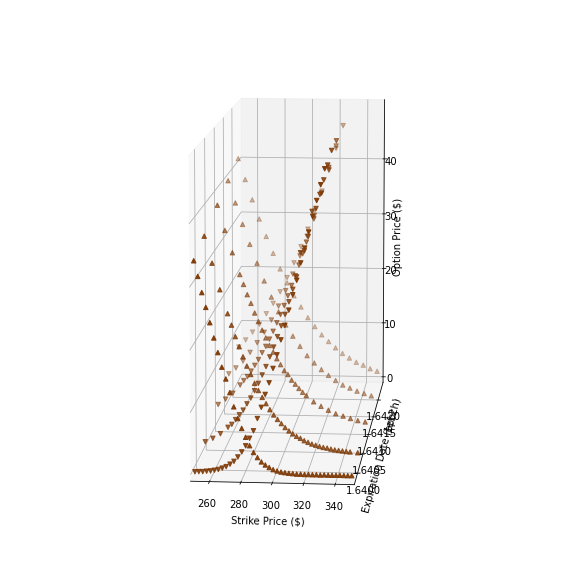

In [25]:
# Visualize options chain as 3D scatter plot
# 1. Prepare figure parameters
fig = plt.figure(figsize=(10,16))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('Strike Price ($)')
ax.set_ylabel('Expiration Date (epoch)')
ax.set_zlabel('Option Price ($)')

# 2. Decide on range of visualization
lowerStrike, upperStrike = 250, 350
lowerExpiry, upperExpiry = 1639774800000, 1642496000000
lowerPrice, upperPrice = 0, 50

ax.set_xlim(left=lowerStrike, right=upperStrike)
ax.set_ylim(bottom=lowerExpiry, top=upperExpiry)
ax.set_zlim(bottom=lowerPrice, top=np.max(df['mark']))

df = df[(df.strikePrice >= lowerStrike) & 
        (df.strikePrice <= upperStrike) &
        (df.expirationDate >= lowerExpiry) &
        (df.expirationDate <= upperExpiry) &
        (df.mark >= lowerPrice) &
        (df.mark <= upperPrice)]

# 3. Filter DF for data within chosen range
df_c = df[(df.putCall == 'CALL')]
df_p = df[(df.putCall == 'PUT')]

# 2. Plot call options with up-arrow marker
x = df_c['strikePrice']
y = df_c['expirationDate']
z = df_c['mark']

hue = df_c['pctChange']
marker = '^'

ax.scatter(x, y, z, 
           c=hue.map(cm.PuOr), 
           marker=marker)

# 3. Plot put options with down-arrow marker
df_p = df[(df.putCall == 'PUT')]
x = df_p['strikePrice']
y = df_p['expirationDate']
z = df_p['mark']

hue = df_p['pctChange']
marker = 'v'

ax.scatter(x, y, z, 
           c=hue.map(cm.PuOr), 
           marker=marker)

# 5. Final adjustments
ax.set_box_aspect((1, 3, 2))
ax.view_init(10, -85)
plt.show()

### 5.0 Combine dataframes

In [8]:
df = pd.read_csv('data/df_0900.csv')
for time in [1000, 1100, 1200, 1300, 1400, 1500, 1600]:
    path = 'data/df_'+str(time)+'.csv'
    df_new = pd.read_csv(path)
    df = pd.concat([df, df_new])
len(df)

27152

In [9]:
df.to_csv('data/df_all.csv')